---
title: "Glomerulus Segmentation"
author: Favian Hatje
date: '11.06.2022'
format:
  html:
    code-fold: false
jupyter: python3
categories: [deep learning, image segmentation]
---

Training an __Unet++__ with fastai to segment glomeruli.

![](zoomed_segmented_gloms.png)

# Model Training Notebook

Here we train a Unet++ architecture with a pretrained efficientnet-b4 backbone from the awesome [segmentation_models_pytorch](https://github.com/qubvel/segmentation_models.pytorch) library. Data loading, transforming, the actual training and, finally, exporting the newly trained model, we use [fastai](https://github.com/fastai/fastai).

Here's a [running example](https://huggingface.co/spaces/fhatje/glomseg) of the model trained with this notebook. 

## Goal

Segmenting glomeruli (an intricate structure in the kidney's cortex in which the blood filtration happen), i.e. turning this

<img src="input_example.png" width="200" style="border-radius: 10px;"/>
to this
<img src="segmented_example.png" width="200" style="border-radius: 10px;"/>


## Data

I am using training data from the [HuBMAP Challenge](https://www.kaggle.com/competitions/hubmap-organ-segmentation/) hosted on kaggle and a few dozen images downloaded from the [Human Protein Atlas](https://www.proteinatlas.org/) I annotated myself. (If you're interested in how to do this, here a [blogpost](/posts/hpa/protein_atlas_scrape.html) I wrote)

In [1]:
import numpy as np
import pandas as pd
import monai
from fastai.vision.all import *
import segmentation_models_pytorch as smp

In [2]:
ORGAN = "kidney"
TRAIN_BATCH_SIZE = 8 # Reduce this, if you run out of cuda memory
EFFECTIVE_BATCH_SIZE = 8 # This is the batch size that will be used for training
IMAGE_SIZE = 512
LR = 3e-4 
EPOCHS = 60
MODEL_NAME = f"smp_{IMAGE_SIZE}_{ORGAN}_added_data"
DATA_PATH = Path("../data/")

In [3]:
# Reproducibility
TESTSET_SEED = 93
TRAIN_VAL_SEED = 43

In [4]:
df = pd.read_csv(DATA_PATH/"train.csv") # This is the training set from the competition
fns = L([*get_image_files(DATA_PATH/"test_images"), *get_image_files(DATA_PATH/"train_images")]) # List of all competition images   
fn_col = [] # This will be a column in the dataframe, containing the filenames
for _, r in df.iterrows(): fn_col.append([fn for fn in fns if str(r["id"]) == fn.stem][0])
df["fnames"] = fn_col
df["is_organ"] = df.organ.apply(lambda o: o==ORGAN)
df = df[df.is_organ] # Only keep images with the organ we are interested in
assert df.organ.unique()[0] == ORGAN
df = df.drop(columns="organ data_source is_organ tissue_thickness pixel_size sex age".split()).copy()

In [5]:
# These are the images I added and that are annotated by me
add_images = get_image_files(DATA_PATH/"add_images/") 
add_images_masks = get_image_files(DATA_PATH/"segs/")

In [6]:
# The masks have the same name as the images, but with "_mask" appended
masks = [p.name[:-9]+".png" for p in add_images_masks] 

# Delete images without masks
images_to_delete = [p for p in add_images if p.name not in masks] 
for p in images_to_delete: p.unlink()

# This will contain the masks in the same order as the images
sorted_masks = [] 
for i in add_images:
    sorted_masks.append([p for p in add_images_masks if i.stem == p.stem[:-5]][0])

In [7]:
# Combine the competition data with the added data
add_df = pd.DataFrame({
    "fnames": add_images,
    "segmentation": sorted_masks,
    "is_add": [True]*len(add_images)
})
df["is_add"] = df.id.apply(lambda p: False)
combined_df = pd.concat([df, add_df])

In [8]:
# Setting aside a random testset
cut = int(0.1 * len(combined_df))
ind = np.arange(len(combined_df))
np.random.seed(TESTSET_SEED) # Always create the same testset
np.random.shuffle(ind)
test_ind = ind[:cut]
train_valid_ind = ind[cut:]
test_df = combined_df.iloc[test_ind,:].copy()
train_df = combined_df.iloc[train_valid_ind,:].copy()

The masks of the competition data are in run-length encoding, that's why we need the following function. It converts the run-length encoding to a numpy array which we can use for training.

In [10]:
# From: https://www.kaggle.com/code/paulorzp/run-length-encode-and-decode/script
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return np.reshape(img, shape)

In [11]:
CODES = ["Background", "FTU"] # FTU = functional tissue unit

In [12]:
def x_getter(r): return r["fnames"]
def y_getter(r): 
    # My additional annotations are saved as pngs, so I need to differ between the two
    if r["is_add"]: 
        im = np.array(load_image(r["segmentation"]), dtype=np.uint8)
        im = (im.mean(axis=-1) < 125).astype(np.uint8)
        return im
    rle = r["rle"]
    shape = (int(r["img_height"]), int(r["img_width"]))
    return rle_decode(rle, shape).T

In [13]:
btfms = aug_transforms(
    mult=1.2,
    do_flip=True,
    flip_vert=True,
    max_rotate=45.0,
    min_zoom=1.,
    max_zoom=1.5,
    max_lighting=0.3,
    max_warp=0.3,
    size=(IMAGE_SIZE, IMAGE_SIZE),
    p_affine=0.5
) # Data augmentation
dblock = DataBlock(blocks=(ImageBlock, MaskBlock(CODES)),
                   get_x=x_getter,
                   get_y=y_getter,
                   splitter=RandomSplitter(seed=TRAIN_VAL_SEED),
                   item_tfms=[Resize((IMAGE_SIZE, IMAGE_SIZE))],
                   batch_tfms=btfms)
dls = dblock.dataloaders(train_df, Path(".."), bs=TRAIN_BATCH_SIZE)

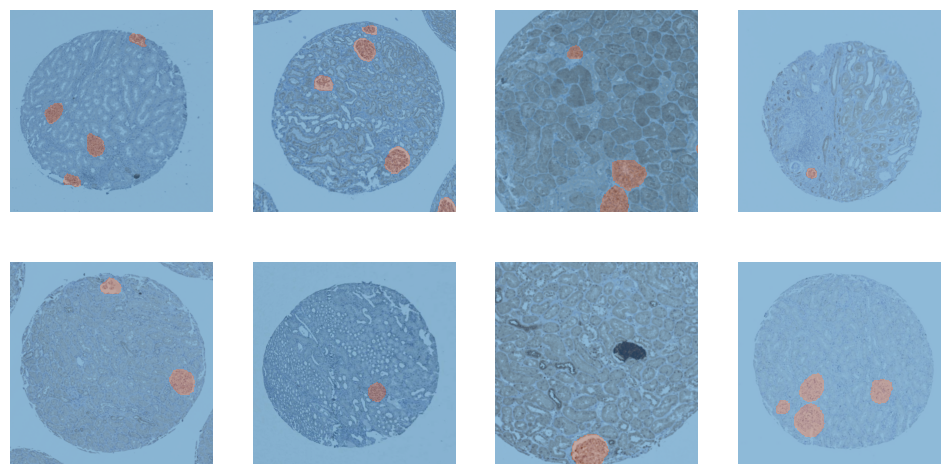

In [14]:
dls.train.show_batch()

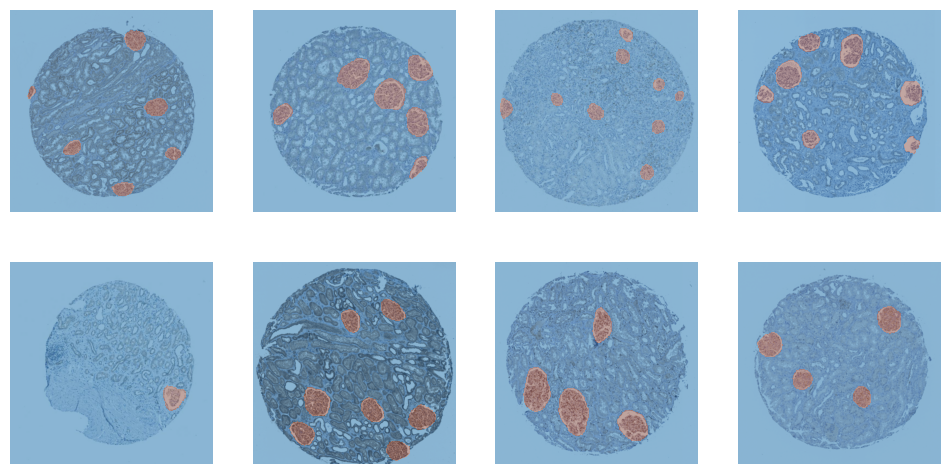

In [15]:
dls.valid.show_batch()

In [16]:
cbs = [
    GradientAccumulation(EFFECTIVE_BATCH_SIZE),
    SaveModelCallback(fname=MODEL_NAME),
]

In [17]:
model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b4",        
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=2,                      
)

In [18]:
# Splitting model's into 2 groups to use fastai's differential learning rates
def splitter(model): 
    enc_params = L(model.encoder.parameters())
    dec_params = L(model.decoder.parameters())
    sg_params = L(model.segmentation_head.parameters())
    untrained_params = L([*dec_params, *sg_params])
    return L([enc_params, untrained_params])

In [19]:
learn = Learner(
    dls, 
    model, 
    cbs=cbs,
    splitter=splitter,
    metrics=[Dice(), JaccardCoeff(), RocAucBinary()])

In [21]:
learn.fit_flat_cos(EPOCHS, LR)

epoch,train_loss,valid_loss,dice,jaccard_coeff,roc_auc_score,time
0,0.727570,0.603148,0.085859,0.044855,0.322773,00:12
1,0.604307,0.516570,0.096767,0.050843,0.427407,00:11
2,0.508117,0.379248,0.522587,0.353718,0.314975,00:11
3,0.424914,0.302621,0.584612,0.413040,0.085511,00:11
4,0.353784,0.207627,0.712757,0.553709,0.128719,00:11
5,0.296790,0.142182,0.830598,0.710276,0.556589,00:11
6,0.250124,0.107157,0.849849,0.738903,0.781829,00:11
7,0.211806,0.088498,0.857634,0.750752,0.867223,00:11
8,0.180824,0.070990,0.859145,0.753071,0.888895,00:11
9,0.154632,0.061644,0.856697,0.749318,0.929199,00:11


Better model found at epoch 0 with valid_loss value: 0.6031481027603149.
Better model found at epoch 1 with valid_loss value: 0.516569972038269.
Better model found at epoch 2 with valid_loss value: 0.3792479634284973.
Better model found at epoch 3 with valid_loss value: 0.302621066570282.
Better model found at epoch 4 with valid_loss value: 0.20762743055820465.
Better model found at epoch 5 with valid_loss value: 0.14218230545520782.
Better model found at epoch 6 with valid_loss value: 0.10715709626674652.
Better model found at epoch 7 with valid_loss value: 0.0884983241558075.
Better model found at epoch 8 with valid_loss value: 0.07099024951457977.
Better model found at epoch 9 with valid_loss value: 0.06164400279521942.
Better model found at epoch 10 with valid_loss value: 0.0527963824570179.
Better model found at epoch 11 with valid_loss value: 0.046286918222904205.
Better model found at epoch 12 with valid_loss value: 0.04076218977570534.
Better model found at epoch 13 with valid_

In [22]:
learn.load(MODEL_NAME)

Saved filed doesn't contain an optimizer state.


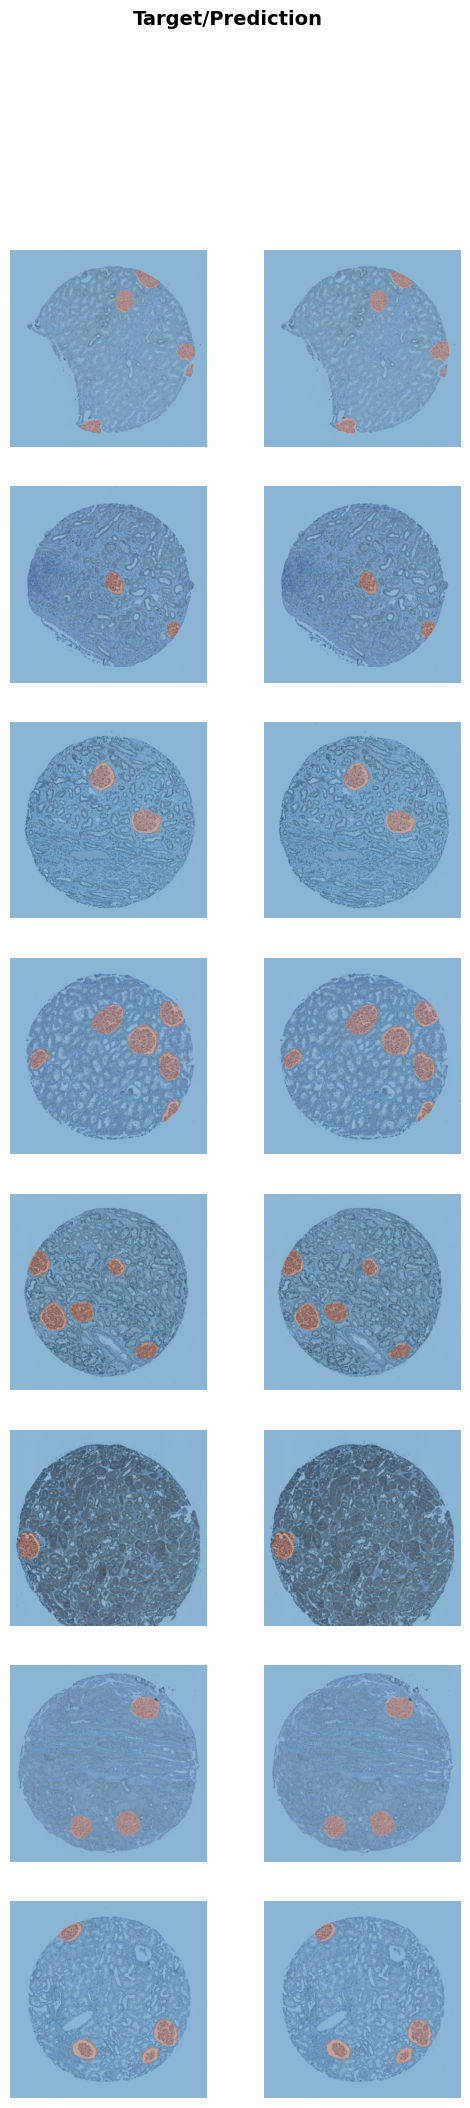

In [23]:
learn.show_results()

In [24]:
# Create a dataloader from the testset
test_dl = dls.test_dl(test_df, with_labels=True)
dice_func = monai.metrics.DiceMetric(include_background=False, reduction="mean")

In [25]:
# This function steps through the different thresholds and returns the best one
def get_best_threshold(learn, dl, metric_func, n_steps=17):
    """
    Tests `n_steps` different thresholds.
    Return the best threshold and the corresonding score.
    """
    thresholds = torch.linspace(0.1, 0.9, n_steps)
    results = []

    res = learn.get_preds(dl=dl, with_input=False, with_targs=True, act=partial(F.softmax, dim=1))
    
    for t in thresholds:
        metric_func((res[0][:,1]>t).unsqueeze(1), res[-1].unsqueeze(1))
        metric = metric_func.aggregate().item()
        metric_func.reset()
        results.append((round(t.detach().cpu().item(), ndigits=3), metric))

    return sorted(results, key=lambda tpl: tpl[1], reverse=True)[0]

In [26]:
best_threshold, _ = get_best_threshold(learn, dls.valid, dice_func)
best_threshold

0.6

And now we test the model on the training, validation and test set with the best threshold.

In [27]:
def test_model(learn, dl, metric_func, threshold=0.5):
    res = learn.get_preds(dl=dl, with_input=False, with_targs=True, act=partial(F.softmax, dim=1))
    metric_func((res[0][:,1]>threshold).unsqueeze(1), res[-1].unsqueeze(1))
    metric = metric_func.aggregate().item()
    metric_func.reset()
    return metric
    
train_dice = test_model(learn, dls.train, dice_func, threshold=best_threshold)
valid_dice = test_model(learn, dls.valid, dice_func, threshold=best_threshold)
test_dice  = test_model(learn, test_dl,   dice_func, threshold=best_threshold)

for s, d in zip(("Training Dice:", "Valid Dice", "Test Dice"), (train_dice, valid_dice, test_dice)):
    print(s, d)

Training Dice: 0.9252251982688904
Valid Dice 0.9271063208580017
Test Dice 0.9414731860160828


In [28]:
# Save and export the model
BEST_MODEL_NAME = f"unetpp_b4_th{int(best_threshold*100)}_d{str(test_dice)[2:6]}"
learn.save(BEST_MODEL_NAME)
learn.export(BEST_MODEL_NAME+".pkl")

A live version of this model is deployed on a [huggingface space](https://huggingface.co/spaces/fhatje/glomseg).